In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchdyn.core import NeuralODE
import pytorch_lightning as pl

from tools.data import LinearData, CubicData

import matplotlib.pyplot as plt
from tqdm.notebook import trange

In [2]:
data = CubicData(np.array([[-0.1, 2.0], [-2.0, -0.1]]), n=300, train_size=10)
dataloader = DataLoader(data, batch_size=20)

In [3]:
class Learner(pl.LightningModule):
    def __init__(self, model:nn.Module):
        super().__init__()
        self.model = model
        self.t = torch.linspace(0,1,300)[:10]

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        y = batch
        y0 = y[:,0]
        t_eval, y_hat = self.model(y0, self.t)
        y_hat = y_hat.transpose(0,1)
        loss = F.l1_loss(y, y_hat)
        return {'loss': loss}

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=1e-3)

    def train_dataloader(self):
        return dataloader

In [4]:
class ODEFunc(nn.Module):

    def __init__(self):
        super(ODEFunc, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(2, 50),
            nn.Tanh(),
            nn.Linear(50, 2)
        )

        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    def forward(self, t, y):
        return self.net(y**3)

In [5]:
f = ODEFunc()
model = NeuralODE(f, sensitivity='adjoint', solver='rk4', solver_adjoint='dopri5', atol_adjoint=1e-4, rtol_adjoint=1e-4)

learn = Learner(model)
trainer = pl.Trainer(max_steps=2000)
trainer.fit(learn)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type      | Params
------------------------------------
0 | model | NeuralODE | 252   
------------------------------------
252       Trainable params
0         Non-trainable params
252       Total params
0.001     Total estimated model params size (MB)
/Users/haru4me/Library/Caches/pypoetry/virtualenvs/nde-XA3e5nDq-py3.9/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/haru4me/Library/Caches/pypoetry/virtualenvs/nde-XA3e5nDq-py3.9/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1933

Training: 0it [00:00, ?it/s]

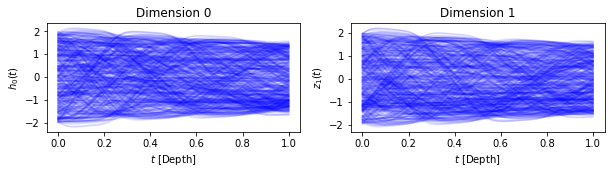

In [6]:
y0 = np.random.uniform(-2,2,size=(500,2))
y0 = torch.Tensor(y0)
t = torch.linspace(0,1,300)
t_eval, trajectory = model(y0, t)
trajectory = trajectory.detach().cpu()

color=['orange', 'blue']


fig = plt.figure(figsize=(10,2))
ax0 = fig.add_subplot(121)
ax1 = fig.add_subplot(122)
ax0.plot(t, trajectory[:,:,0], color=color[1], alpha=.1);
ax1.plot(t, trajectory[:,:,1], color=color[1], alpha=.1);
ax0.set_xlabel(r"$t$ [Depth]") ; ax0.set_ylabel(r"$h_0(t)$")
ax1.set_xlabel(r"$t$ [Depth]") ; ax1.set_ylabel(r"$z_1(t)$")
ax0.set_title("Dimension 0") ; ax1.set_title("Dimension 1")
plt.show()

In [7]:
class Lambda(nn.Module):

    def forward(self, t, y):
        true_A = torch.tensor([[-0.1, 2.0], [-2.0, -0.1]])
        return torch.mm(y**3, true_A)

Your vector field does not have `nn.Parameters` to optimize.


/Users/haru4me/Library/Caches/pypoetry/virtualenvs/nde-XA3e5nDq-py3.9/lib/python3.9/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /Users/distiller/project/pytorch/aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


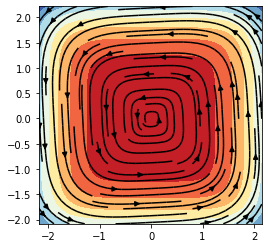

In [8]:
true_model = NeuralODE(Lambda(), sensitivity='adjoint', solver='rk4', solver_adjoint='dopri5', atol_adjoint=1e-4, rtol_adjoint=1e-4)
n_pts = 50
x = torch.linspace(trajectory[:,:,0].min(), trajectory[:,:,0].max(), n_pts)
y = torch.linspace(trajectory[:,:,1].min(), trajectory[:,:,1].max(), n_pts)
X, Y = torch.meshgrid(x, y) ; z = torch.cat([X.reshape(-1,1), Y.reshape(-1,1)], 1)
f = true_model.vf(0,z).cpu().detach()
fx, fy = f[:,0], f[:,1] ; fx, fy = fx.reshape(n_pts , n_pts), fy.reshape(n_pts, n_pts)
# plot vector field and its intensity
fig = plt.figure(figsize=(4, 4)) ; ax = fig.add_subplot(111)
ax.streamplot(X.numpy().T, Y.numpy().T, fx.numpy().T, fy.numpy().T, color='black')
ax.contourf(X.T, Y.T, torch.sqrt(fx.T**2+fy.T**2), cmap='RdYlBu')
plt.show()

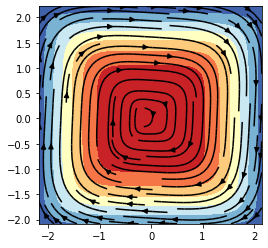

In [9]:
n_pts = 50
x = torch.linspace(trajectory[:,:,0].min(), trajectory[:,:,0].max(), n_pts)
y = torch.linspace(trajectory[:,:,1].min(), trajectory[:,:,1].max(), n_pts)
X, Y = torch.meshgrid(x, y) ; z = torch.cat([X.reshape(-1,1), Y.reshape(-1,1)], 1)
f = model.vf(0,z).cpu().detach()
fx, fy = f[:,0], f[:,1] ; fx, fy = fx.reshape(n_pts , n_pts), fy.reshape(n_pts, n_pts)
# plot vector field and its intensity
fig = plt.figure(figsize=(4, 4)) ; ax = fig.add_subplot(111)
ax.streamplot(X.numpy().T, Y.numpy().T, fx.numpy().T, fy.numpy().T, color='black')
ax.contourf(X.T, Y.T, torch.sqrt(fx.T**2+fy.T**2), cmap='RdYlBu')
plt.show()

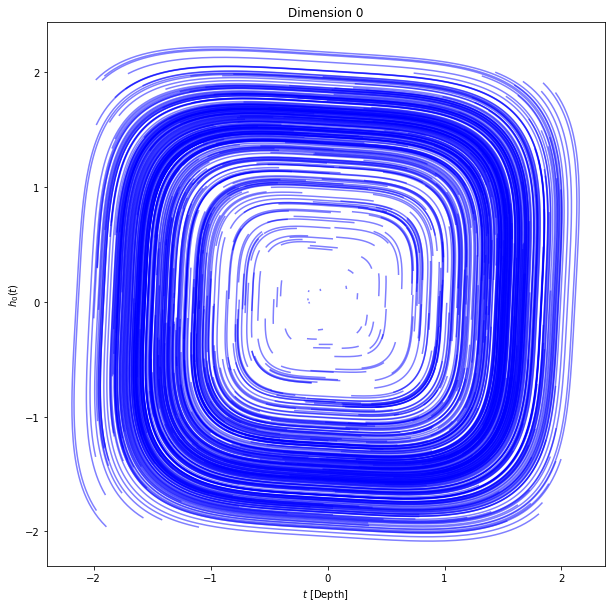

In [10]:
fig = plt.figure(figsize=(10,10))
ax0 = fig.add_subplot(111)
ax0.plot(trajectory[:,:,0], trajectory[:,:,1], color=color[1], alpha=.5);
ax0.set_xlabel(r"$t$ [Depth]") ; ax0.set_ylabel(r"$h_0(t)$")
ax1.set_xlabel(r"$t$ [Depth]") ; ax1.set_ylabel(r"$z_1(t)$")
ax0.set_title("Dimension 0") ; ax1.set_title("Dimension 1")
plt.show()

  0%|          | 0/500 [00:00<?, ?it/s]

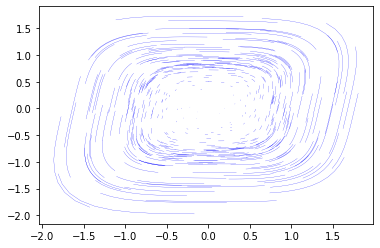

In [30]:
for i in trange(500):
    t0, t1, y0, y1 = data[i]
    plt.plot(y0[:,0],y0[:,1], alpha=1, lw=0.2, c='blue')
    #plt.plot(t1,y1[:,0], alpha=1, lw=0.2, c='orange')
plt.show()

In [12]:
import time
from torchdyn.numerics import Euler, RungeKutta4, Tsitouras45, DormandPrince45, MSZero, Euler, HyperEuler
from torchdyn.numerics import odeint, odeint_mshooting, Lorenz
from torchdyn.core import ODEProblem, MultipleShootingProblem

In [17]:
Lorenz().p.weight.data

tensor([[0.4229]])

In [22]:
x0 = torch.randn(50, 3) + 15
t_span = torch.linspace(0, 5, 500)
sys = Lorenz()

In [23]:
t0 = time.time()
t_eval, accurate_sol = odeint(sys, x0, t_span, solver='dopri5', atol=1e-6, rtol=1e-6)
accurate_sol_time = time.time() - t0

t0 = time.time()
t_eval, base_sol = odeint(sys, x0, t_span, solver='euler')
base_sol_time = time.time() - t0

t0 = time.time()
t_eval, rk4_sol = odeint(sys, x0, t_span, solver='rk4')
rk4_sol_time = time.time() - t0

t0 = time.time()
t_eval, dp5_low_sol = odeint(sys, x0, t_span, solver='dopri5', atol=1e-3, rtol=1e-3)
dp5_low_time = time.time() - t0

In [24]:
prob = ODEProblem(sys, sensitivity='interpolated_adjoint', solver='dopri5', atol=1e-3, rtol=1e-3,
                  solver_adjoint='tsit5', atol_adjoint=1e-3, rtol_adjoint=1e-3)
t0 = time.time()
t_eval, sol_torchdyn = prob.odeint(x0, t_span)
t_end1 = time.time() - t0

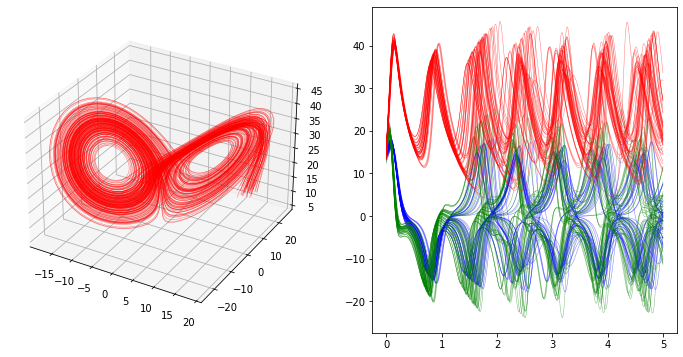

In [32]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(1,2,1, projection='3d')
ax1 = fig.add_subplot(1,2,2)

for i in range(dp5_low_sol.shape[1]):
    ax.plot(dp5_low_sol[:,i,0].detach().numpy(), dp5_low_sol[:,i,1].detach().numpy(), dp5_low_sol[:,i,2].detach().numpy(), linewidth=0.5, alpha=0.5, c='r')
ax1.plot(t_eval.detach().numpy(), dp5_low_sol[:,:,0].detach().numpy(), c='b', linewidth=0.5, alpha=0.5)
ax1.plot(t_eval.detach().numpy(), dp5_low_sol[:,:,1].detach().numpy(), c='g', linewidth=0.5, alpha=0.5)
ax1.plot(t_eval.detach().numpy(), dp5_low_sol[:,:,2].detach().numpy(), c='r', linewidth=0.5, alpha=0.5)

#ax = [ax1, ax2]
#ax1.plot(y[:,0], y[:,1], y[:,2], lw=0.5, c='r')
#ax1.set_xlabel('$x_1$', size=20)
#ax1.set_ylabel('$x_2$', size=20)
#ax1.set_zlabel('$x_3$', size=20)

plt.show()

In [26]:
class VanillaHyperNet(nn.Module):
    def __init__(self, net):
        super().__init__()
        self.net = net
        for p in self.net.parameters():
            torch.nn.init.uniform_(p, 0, 1e-5)
    def forward(self, t, x):
        return self.net(x)

In [30]:
net = nn.Sequential(nn.Linear(3, 64), nn.Softplus(), nn.Linear(64, 64), nn.Softplus(), nn.Linear(64, 3))
hypersolver = HyperEuler(VanillaHyperNet(net))
t_eval, sol = odeint(sys, x0, t_span, solver='rk4') # note: this has to be trained!

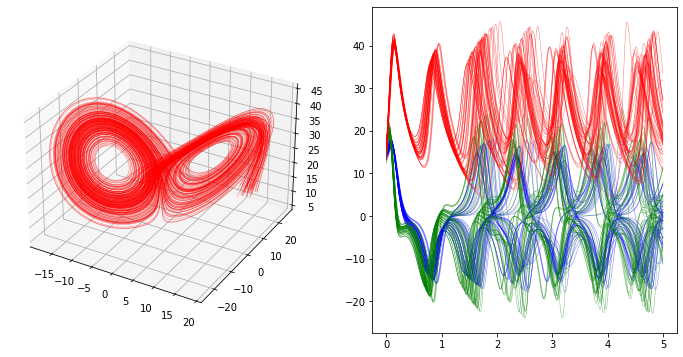

In [31]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(1,2,1, projection='3d')
ax1 = fig.add_subplot(1,2,2)

for i in range(sol.shape[1]):
    ax.plot(sol[:,i,0].detach().numpy(), sol[:,i,1].detach().numpy(), sol[:,i,2].detach().numpy(), linewidth=0.5, alpha=0.5, c='r')
ax1.plot(t_eval.detach().numpy(), sol[:,:,0].detach().numpy(), c='b', linewidth=0.5, alpha=0.5)
ax1.plot(t_eval.detach().numpy(), sol[:,:,1].detach().numpy(), c='g', linewidth=0.5, alpha=0.5)
ax1.plot(t_eval.detach().numpy(), sol[:,:,2].detach().numpy(), c='r', linewidth=0.5, alpha=0.5)

#ax = [ax1, ax2]
#ax1.plot(y[:,0], y[:,1], y[:,2], lw=0.5, c='r')
#ax1.set_xlabel('$x_1$', size=20)
#ax1.set_ylabel('$x_2$', size=20)
#ax1.set_zlabel('$x_3$', size=20)

plt.show()

In [40]:
import imageio
from tqdm.notebook import tqdm
images = []
for filename in tqdm([f'assets/demo_imgs/{i}.png' for i in range(40)]):
    images.append(imageio.imread(filename))
imageio.mimsave('assets/cubic.gif', images)

  0%|          | 0/40 [00:00<?, ?it/s]

/var/folders/qg/xpf_3z654rz2wkstrmbrx7_00000gn/T/ipykernel_16989/3041445994.py:5: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(filename))
